# Comparison: Clustered vs Standard Parameterization using XY mixer and Dicke Initialization
* This notebook uses local `qiskit.statevector_simulator` as the device to run k-Dicke initialized QAOA program with XY mixer comparing the Clustered and Standard Parameterizations on problems that are challenging for Vanilla QAOA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('custom')
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.problems import Knapsack, MaximumCut, NumberPartition
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *

### Problem construction
* randomly initialize (or explicitly specify) a set of numbers to be partitioned
* translate the list of numbers into the QUBO form and extract the cost Hamiltonian from it
* get the exact solution of the problem by calling the `ground_state_hamiltonian` function 
* Initialize the mixer of choice to be used in the QAOA routine

In [9]:
# nums=list(np.random.randint(0,200,9))
nums = [85, 96, 80, 96, 96, 97, 90, 80, 81]
cost_prob = NumberPartition(nums).get_qubo_problem()
cost_hamil = cost_prob.hamiltonian
n_qubits = cost_hamil.n_qubits

In [5]:
nums

[15, 128, 77, 36, 43, 173, 181, 82, 88]

In [10]:
#print the solution to the problem
print(ground_state_hamiltonian(cost_hamil))

(961.0, ['010111000', '101000111'])


In [11]:
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

### Construct workflow objects
* Create the QAOACircuitParams object -> responsible for the creating the abstract QAOA circuit from cost and mixer Hamiltonians
* Create and initialize the chosen Variational Parameters (for this notebook, we choose to compare Standard vs Clustered params)
* Create the backend object with prepend_states and the chosen device 

In [12]:
p=4
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=4)

In [13]:
max_std_dev=2
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev, n_clusters=0)
variate_params_clustered_kmeans = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev, n_clusters=4)
variate_params_clustered_kmeans8 = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev, n_clusters=8)
variate_params_clustered_kmeans16 = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev, n_clusters=16)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')
variate_params_extended = create_qaoa_variational_params(circuit_params,'extended','ramp')

Using the sharma parametrisation
Using the sharma parametrisation
Using k-means
Using k-means
Using k-means
Using k-means
Using k-means
Using k-means


In [14]:
k_excitations = 3
prepend_state = dicke_wavefunction(k_excitations,n_qubits = n_qubits)
init_hadamard = False

In [15]:
device = create_device('local','qiskit.statevector_simulator')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

### Prepare the Optimizer to work with Variational Params and Backend
* specify optimization method and maxiters
* create different optimizer objects for clustered and standard params
* Perform the optimization

In [16]:
optimizer_dict = {'method': 'cobyla', 'maxiter': 2000}

In [18]:
optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
optimizer_obj_extended = get_optimizer(backend_obj, variate_params_extended, optimizer_dict)
optimizer_obj_clustered = get_optimizer(backend_obj, variate_params_clustered, optimizer_dict)
optimizer_obj_clustered_kmeans = get_optimizer(backend_obj, variate_params_clustered_kmeans, optimizer_dict)
optimizer_obj_clustered_kmeans8 = get_optimizer(backend_obj, variate_params_clustered_kmeans8, optimizer_dict)
optimizer_obj_clustered_kmeans16 = get_optimizer(backend_obj, variate_params_clustered_kmeans16, optimizer_dict)

In [19]:
optimizer_obj_standard()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: COBYLA with Max Iterations: 2000

In [20]:
optimizer_obj_extended()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: COBYLA with Max Iterations: 2000

In [21]:
optimizer_obj_clustered()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: COBYLA with Max Iterations: 2000

In [22]:
optimizer_obj_clustered_kmeans()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: COBYLA with Max Iterations: 2000

In [23]:
optimizer_obj_clustered_kmeans8()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: COBYLA with Max Iterations: 2000

In [24]:
optimizer_obj_clustered_kmeans16()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: COBYLA with Max Iterations: 2000

### Extract Results from the optimization runs
* Since this notebook compares the Clustered and Standard Parameterizations, extract the results obtained from the two optimization runs for comparison
* Plot cost history, probability overlap with low energy states, probability distribution over basis states

In [25]:
cost_history_clustered = optimizer_obj_clustered.qaoa_result.intermediate['intermediate cost']
cost_history_standard = optimizer_obj_standard.qaoa_result.intermediate['intermediate cost']
cost_history_extended = optimizer_obj_extended.qaoa_result.intermediate['intermediate cost']
cost_history_clustered_kmeans = optimizer_obj_clustered_kmeans.qaoa_result.intermediate['intermediate cost']
cost_history_clustered_kmeans8 = optimizer_obj_clustered_kmeans8.qaoa_result.intermediate['intermediate cost']
cost_history_clustered_kmeans16 = optimizer_obj_clustered_kmeans16.qaoa_result.intermediate['intermediate cost']

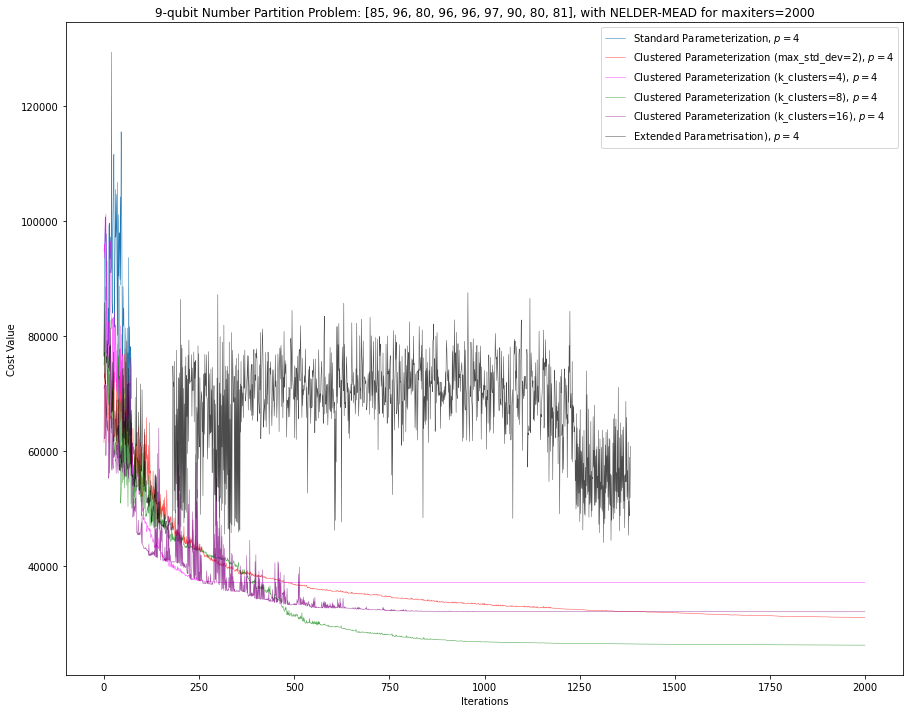

In [37]:
plt.figure(figsize=(15,12))
plt.plot(cost_history_standard,label=f'Standard Parameterization, $p={p}$',lw=0.5)
plt.plot(cost_history_clustered, color='red',label=f'Clustered Parameterization (max_std_dev={max_std_dev}), $p={p}$',lw=0.5,alpha=0.7)
plt.plot(cost_history_clustered_kmeans, color='magenta',label=f'Clustered Parameterization (k_clusters={4}), $p={p}$',lw=0.5,alpha=0.7)
plt.plot(cost_history_clustered_kmeans8, color='green',label=f'Clustered Parameterization (k_clusters={8}), $p={p}$',lw=0.5,alpha=0.7)
plt.plot(cost_history_clustered_kmeans16, color='purple',label=f'Clustered Parameterization (k_clusters={16}), $p={p}$',lw=0.5,alpha=0.7)
plt.plot(cost_history_extended, color='black',label=f'Extended Parametrisation), $p={p}$',lw=0.5,alpha=0.7)
# plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost Value')
plt.legend();
plt.title(f'9-qubit Number Partition Problem: {nums}, with NELDER-MEAD for maxiters=2000');
plt.savefig(f'images/9-qubit Number Partition Problem : {nums}.pdf')

In [35]:
import pandas as pd

In [62]:
df = pd.DataFrame([cost_history_standard,cost_history_extended,cost_history_clustered,cost_history_clustered_kmeans, cost_history_clustered_kmeans8,cost_history_clustered_kmeans16]).T
df.columns = ['standard', 'extended', 'clustered', 'kmeans4', 'kmeans8', 'kmeans16']
df['standard'].min(), df['kmeans8'].min(), df['clustered'].min()

(57673.03156796617, 26246.543860897116, 31062.550834442423)

In [27]:
counts_dict_clustered = optimizer_obj_clustered.qaoa_result.get_counts(optimizer_obj_clustered.qaoa_result.optimized['optimized measurement outcomes'])
counts_dict_standard = optimizer_obj_standard.qaoa_result.get_counts(optimizer_obj_standard.qaoa_result.optimized['optimized measurement outcomes'])
counts_dict_clustered_kmeans = optimizer_obj_clustered_kmeans.qaoa_result.get_counts(optimizer_obj_clustered_kmeans.qaoa_result.optimized['optimized measurement outcomes'])
counts_dict_clustered_kmeans8 = optimizer_obj_clustered_kmeans8.qaoa_result.get_counts(optimizer_obj_clustered_kmeans8.qaoa_result.optimized['optimized measurement outcomes'])
counts_dict_clustered_kmeans16 = optimizer_obj_clustered_kmeans8.qaoa_result.get_counts(optimizer_obj_clustered_kmeans16.qaoa_result.optimized['optimized measurement outcomes'])
counts_dict_clustered_extended = optimizer_obj_extended.qaoa_result.get_counts(optimizer_obj_extended.qaoa_result.optimized['optimized measurement outcomes'])

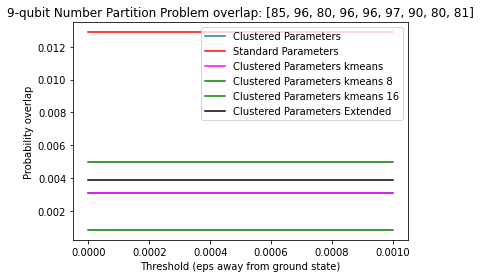

In [28]:
eps = np.linspace(0,0.001,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered) for ep in eps])
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_standard) for ep in eps],color='red')
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered_kmeans) for ep in eps],color='magenta')
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered_kmeans8) for ep in eps],color='green')
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered_kmeans16) for ep in eps],color='green')
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered_extended) for ep in eps],color='black')
plt.legend(['Clustered Parameters','Standard Parameters', 'Clustered Parameters kmeans', 'Clustered Parameters kmeans 8', 'Clustered Parameters kmeans 16', 'Clustered Parameters Extended'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

In [29]:
counts_dict_standard_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_standard)
counts_dict_clustered_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_clustered)
counts_dict_clustered_kmeans_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_clustered_kmeans)

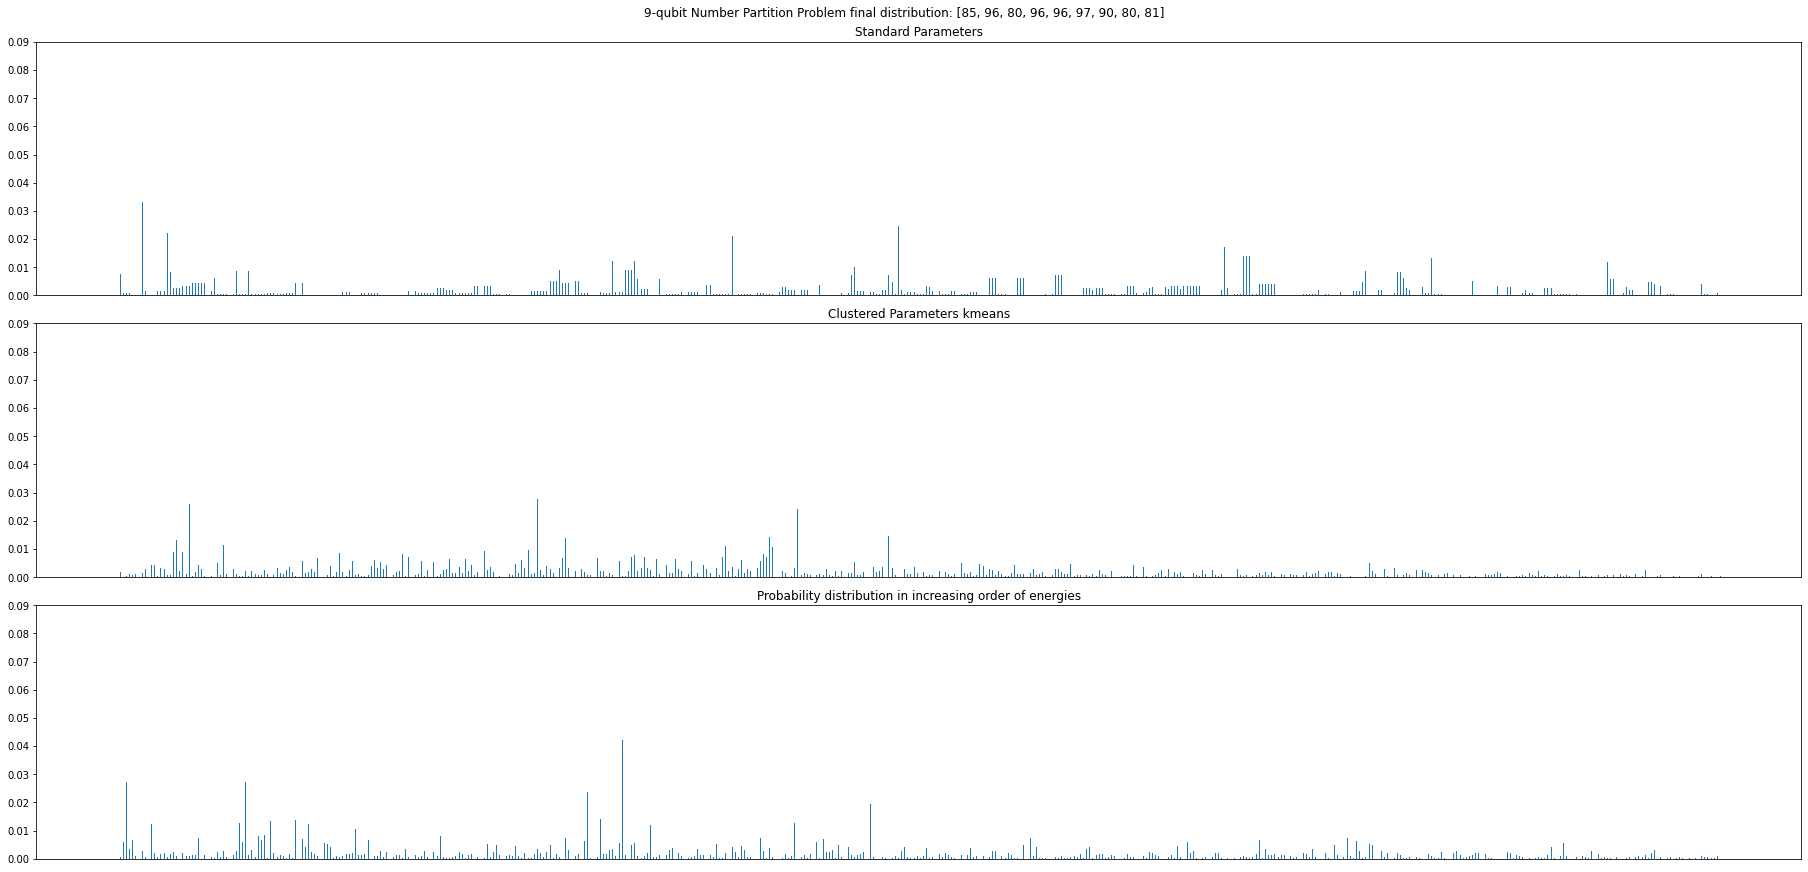

In [30]:
fig,axes = plt.subplots(3,1,figsize=(25,12),constrained_layout=True,sharey=True,sharex=True)
plot_counts(counts_dict_standard_sorted,False,axes[0])
plot_counts(counts_dict_clustered_sorted,False,axes[1])
plot_counts(counts_dict_clustered_kmeans_sorted,False,axes[2])
axes[0].set_title('Standard Parameters')
axes[1].set_title('Clustered Parameters');
axes[1].set_title('Clustered Parameters kmeans');
plt.suptitle(f'9-qubit Number Partition Problem final distribution: {nums}');
plt.ylim([0,0.09]);
# plt.savefig(f'images/9-qubit Number Partition Problem final energy distribution: {nums}.pdf')